In [1]:
import tifffile
import h5py
import os
import random
from datetime import datetime
import numpy as np
import torch
import rasterio
from rasterio.plot import show

from scipy.interpolate import griddata
import matplotlib.pyplot as plt



# Dữ liệu ảnh Radar

*  Khoảng thời gian: tháng 4, 10 năm 2019, 2020
*  Độ phân giải không gian: 0.04 độ ~ 4KM
*  Độ phân giải thời gian: 1 giờ






In [2]:
def tiff_info(tiff_file):
        with rasterio.open(tiff_file) as image:
                transform = image.transform
                crs = image.crs
                bounds = image.bounds
                width = image.width
                height = image.height
                band = image.count


                pixel_width = transform.a
                pixel_height = -transform.e

        
                top_left_x, top_left_y = transform * (0, 0)  

                bottom_right_x, bottom_right_y = transform * (width, height)  

                center_x = bounds.left + (bounds.right - bounds.left) / 2
                center_y = bounds.bottom + (bounds.top - bounds.bottom) / 2

                print("THÔNG TIN ẢNH RADAR 0h-01/04/2020:")
                print(f"- Kích thước ảnh (bands, height, width): ({band}, {height}, {width})")
                print(f"- Hệ tọa độ CRS: {crs}")
                print("Độ phân giải không gian:")
                print(f"  + Theo chiều ngang (X / Lon): {pixel_width}")
                print(f"  + Theo chiều dọc (Y / Lat): {pixel_height}")
                print("Bounding Box:")
                print(f"  + Góc trên-trái:    ({bounds.left}, {bounds.top})")
                print(f"  + Góc dưới-phải:    ({bounds.right}, {bounds.bottom})")
                print("Tọa độ tâm ảnh:")
                print(f"  + ({center_x}, {center_y})")


                
                image_array = image.read(1)
                show(image_array)

THÔNG TIN ẢNH RADAR 0h-01/04/2020:
- Kích thước ảnh (bands, height, width): (1, 90, 250)
- Hệ tọa độ CRS: EPSG:4326
Độ phân giải không gian:
  + Theo chiều ngang (X / Lon): 0.04
  + Theo chiều dọc (Y / Lat): 0.04
Bounding Box:
  + Góc trên-trái:    (101.0, 21.1)
  + Góc dưới-phải:    (111.0, 17.5)
Tọa độ tâm ảnh:
  + (106.0, 19.3)


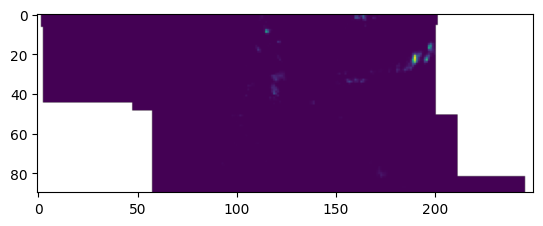

In [3]:
tiff_file = './dataset/2019/04/01/Radar_20190401000000.tif'

tiff_info(tiff_file)

THÔNG TIN ẢNH RADAR 0h-01/04/2020:
- Kích thước ảnh (bands, height, width): (1, 90, 250)
- Hệ tọa độ CRS: EPSG:4326
Độ phân giải không gian:
  + Theo chiều ngang (X / Lon): 0.04
  + Theo chiều dọc (Y / Lat): 0.04
Bounding Box:
  + Góc trên-trái:    (101.0, 21.1)
  + Góc dưới-phải:    (111.0, 17.5)
Tọa độ tâm ảnh:
  + (106.0, 19.3)


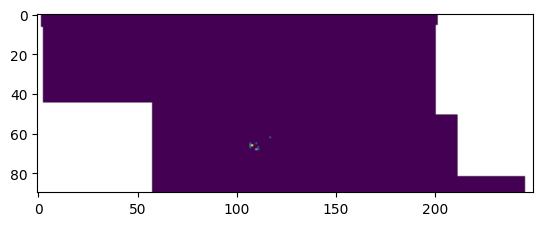

In [4]:
tiff_file = './dataset/2020/04/01/Radar_20200401000000.tif'

tiff_info(tiff_file)


# Giới hạn không gian:


*  Kinh độ: 101 - 111 độ
*  Vĩ độ: 21.1 - 17.5 độ




# Kiểm tra dữ liệu bị mất

In [5]:
import os
from datetime import datetime

def missing_data(tiff_dir):
    days = []
    for root, dirs, files in os.walk(tiff_dir):
        if root != tiff_dir:
            day = os.path.basename(root)
            days.append(day)

    # Sắp xếp các ngày
    days.sort()

    missing_hours = []
    missing_days = []
    days_with_missing_hours = []

    # Kiểm tra số ngày trong tháng
    total_days_in_month = 30 if "04" in tiff_dir else 31

    # Duyệt qua từng ngày
    for i in range(1, total_days_in_month + 1):
        day_str = f"{i:02d}"
        if day_str not in days:
            missing_days.append(day_str)
        else:
            day_path = os.path.join(tiff_dir, day_str)
            print(f"Ngày: {day_str}")

            files_with_time = []

            for file_name in os.listdir(day_path):
                if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                    try:
                        date_str = file_name.split('_')[1][0:14]  # yyyyMMddhhmmss
                        date = datetime.strptime(date_str, '%Y%m%d%H%M%S')
                        hour = date.strftime('%H:%M')  # HH:mm
                        files_with_time.append((file_name, hour))
                    except Exception as e:
                        print(f"Lỗi khi xử lý tệp {file_name}: {e}")

            files_with_time.sort(key=lambda x: datetime.strptime(x[1], '%H:%M'))

            existing_hours = {hour for _, hour in files_with_time}
            all_hours = {f"{str(h).zfill(2)}:00" for h in range(24)}

            missing = all_hours - existing_hours

            if missing:
                print(f"  Thiếu các giờ sau:")
                for hour in sorted(missing):
                    missing_hours.append(f"{day_str} {hour}")
                    print(f"    {hour}")
                days_with_missing_hours.append(day_str)
            else:
                print("  Không thiếu giờ nào trong ngày.")

    if missing_days:
        print("\nCác ngày thiếu hoàn toàn trong tháng:")
        for missing_day in missing_days:
            print(f"  Ngày: {missing_day}")
    else:
        print("\nKhông thiếu ngày nào trong tháng.")

    if days_with_missing_hours:
        print("\nCác ngày bị thiếu một số giờ:")
        for d in days_with_missing_hours:
            print(f"  Ngày: {d}")
    else:
        print("\nKhông có ngày nào bị thiếu giờ.")

  


In [6]:
tiff_dir = './dataset/2019/04'
missing_data(tiff_dir)


Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Không thiếu giờ nào trong ngày.
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Không thiếu giờ nào trong ngày.
Ngày: 24
  

Dữ liệu trong tháng 4 năm 2019 đầy đủ

In [7]:
tiff_dir = './dataset/2019/10'
missing_data(tiff_dir)


Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Thiếu các giờ sau:
    09:00
    10:00
    11:00
    12:00
    13:00
    14:00
    15:00
    16:00
    17:00
    18:00
    19:00
    20:00
    21:00
    22:00
    23:00
Ngày: 08
  Thiếu các giờ sau:
    00:00
    01:00
    02:00
    03:00
    20:00
    21:00
    22:00
    23:00
Ngày: 10
  Thiếu các giờ sau:
    00:00
    01:00
    02:00
    03:00
    04:00
    05:00
    06:00
    07:00
    08:00
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Thiếu các giờ sau:
    13:00
    16:00
    18:00
    19:00
    20:00
    21:00
Ngày: 16
  Thiếu các giờ sau:
    02:00
    03:00
    04:00
    05:00
    18:00
    20:00
    21:00
    22:00
    23:00
Ngày: 17
  Thiếu các giờ sau:
    00:00
    01:00
    18:00
    19:00
    20:00

Dữ liệu trong tháng 10 năm 2019 bị thiếu mất 5 ngày và có 1 vài ngày bị thiếu khá nhiều khoảng thời gian trong ngày như ngày 4, 8, 10, 15, 16, 17 ,18 ,19, 20, 23, 26 ,27, 29, 30 

In [8]:
tiff_dir = './dataset/2020/04'
missing_data(tiff_dir)


Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Không thiếu giờ nào trong ngày.
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Không thiếu giờ nào trong ngày.
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Thiếu các giờ sau:
    18:00
    19:00
    

Dữ liệu trong tháng 4 năm 2020 bị thiếu mất 7 ngày cuối tháng và thiếu 6 tiếng cuối ngày 23

In [9]:
tiff_dir = './dataset/2020/10'
missing_data(tiff_dir)


Ngày: 01
  Không thiếu giờ nào trong ngày.
Ngày: 02
  Thiếu các giờ sau:
    03:00
    06:00
    08:00
Ngày: 03
  Không thiếu giờ nào trong ngày.
Ngày: 04
  Không thiếu giờ nào trong ngày.
Ngày: 05
  Không thiếu giờ nào trong ngày.
Ngày: 06
  Không thiếu giờ nào trong ngày.
Ngày: 07
  Không thiếu giờ nào trong ngày.
Ngày: 08
  Không thiếu giờ nào trong ngày.
Ngày: 09
  Không thiếu giờ nào trong ngày.
Ngày: 10
  Không thiếu giờ nào trong ngày.
Ngày: 11
  Không thiếu giờ nào trong ngày.
Ngày: 12
  Không thiếu giờ nào trong ngày.
Ngày: 13
  Không thiếu giờ nào trong ngày.
Ngày: 14
  Không thiếu giờ nào trong ngày.
Ngày: 15
  Không thiếu giờ nào trong ngày.
Ngày: 16
  Không thiếu giờ nào trong ngày.
Ngày: 17
  Không thiếu giờ nào trong ngày.
Ngày: 18
  Không thiếu giờ nào trong ngày.
Ngày: 19
  Không thiếu giờ nào trong ngày.
Ngày: 20
  Thiếu các giờ sau:
    08:00
Ngày: 21
  Không thiếu giờ nào trong ngày.
Ngày: 22
  Không thiếu giờ nào trong ngày.
Ngày: 23
  Thiếu các giờ sau:
    01:00


Dữ liệu trong tháng 10 năm 2020 không thiếu ngày nào và thiếu ít giờ trong ngày 2 ,20 , 23, 26, 27 28 , 29

# **Nhận xét**


*  Có nhiều thời điểm bị mất dữ liệu, như tháng 10 năm 2020 bị mất nhiều ngày, tháng 10 năm 2019 bị mất nhiều giờ trong ngày



# Xử lí dữ liệu ảnh

In [10]:
def image_value(tiff):
    with rasterio.open(tiff) as image:
        image_array = image.read(1)
        num_neg_inf = np.sum(image_array == -np.inf)
        total_elements = image_array.size
        percentage_neg_inf = (num_neg_inf / total_elements) * 100
        print(f"Tỷ lệ phần trăm giá trị -inf: {percentage_neg_inf:.2f}%")

        image_array[image_array == -np.inf] = np.nan
        min_val = np.nanmin(image_array)
        max_val = np.nanmax(image_array)
        mean_val = np.nanmean(image_array)
        median_val = np.nanmedian(image_array)

        print(f"\nThông tin giá trị ảnh (không tính -inf):")
        print(f"  + Giá trị nhỏ nhất: {min_val}")
        print(f"  + Giá trị lớn nhất: {max_val}")
        print(f"  + Giá trị trung bình: {mean_val}")
        print(f"  + Giá trị trung vị: {mean_val}")

        show(image_array)

Tỷ lệ phần trăm giá trị -inf: 28.45%

Thông tin giá trị ảnh (không tính -inf):
  + Giá trị nhỏ nhất: 0.0
  + Giá trị lớn nhất: 67.3125
  + Giá trị trung bình: 0.1202249750494957
  + Giá trị trung vị: 0.1202249750494957


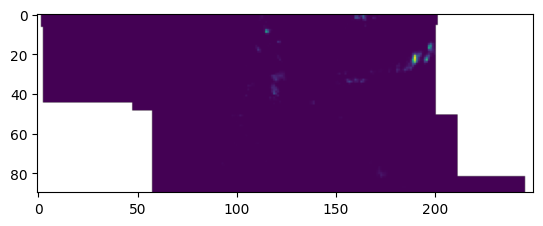

In [11]:
tiff_2019 = './dataset/2019/04/01/Radar_20190401000000.tif'
image_value(tiff_2019)


Tỷ lệ phần trăm giá trị -inf: 28.63%

Thông tin giá trị ảnh (không tính -inf):
  + Giá trị nhỏ nhất: 0.0
  + Giá trị lớn nhất: 0.02500000037252903
  + Giá trị trung bình: 5.837847766088089e-06
  + Giá trị trung vị: 5.837847766088089e-06


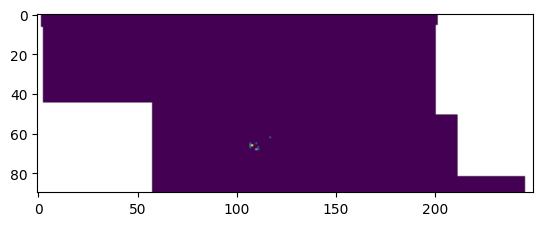

In [12]:
tiff_2020 = './dataset/2020/04/01/Radar_20200401000000.tif'
image_value(tiff_2020)

# **Nhận xét**

*   Do phạm vi hoạt động của Radar có giới hạn nên ảnh Radar sẽ có những vùng
trắng có giá trị -inf.
*   Những ảnh radar trong cùng 1 năm bị khuyết giống nhau
*   Có sự khác nhau trong khoảng trắng của năm 2019 và 2020
*   Sử dụng nội suy lân cận để fill lại khoảng trắng



In [13]:
def calculate_rainfall(tiff_dir):
    days = []
    daily_rainfall = {}  
    
    for root, dirs, files in os.walk(tiff_dir):
        if root != tiff_dir:
            day = os.path.basename(root)
            days.append(day)

    # Sắp xếp các ngày
    days.sort()


    total_days_in_month = 30 if "04" in tiff_dir else 31

    # Duyệt qua từng ngày
    for i in range(1, total_days_in_month + 1):
        day_str = f"{i:02d}"
        if day_str in days:
            day_path = os.path.join(tiff_dir, day_str)

            total_rain_for_day = 0  

            for file_name in os.listdir(day_path):
                if file_name.startswith('Radar_') and file_name.endswith('.tif'):
                    try:
                        
                        date_str = file_name.split('_')[1][0:14]  # yyyyMMddHHmmss
                        date = datetime.strptime(date_str, '%Y%m%d%H%M%S')

                      
                        tiff_path = os.path.join(day_path, file_name)
                        with rasterio.open(tiff_path) as src:
                            data = src.read(1)  
                            data = np.nan_to_num(data, nan=0, neginf=0)

                            total_rain_for_day += np.sum(data)

                    except Exception as e:
                        print(f"Lỗi khi xử lý tệp {file_name}: {e}")

          
            daily_rainfall[day_str] = total_rain_for_day
            
 
    total_rain_in_month = sum(daily_rainfall.values())
    print(f"Tổng lượng mưa trong tháng: {total_rain_in_month:.2f} mm")


    plt.figure(figsize=(10, 6))
    days_sorted = sorted(daily_rainfall.keys())  
    rainfall_values = [daily_rainfall[day] for day in days_sorted]

    plt.bar(days_sorted, rainfall_values)
    plt.xlabel('Ngày')
    plt.ylabel('Tổng lượng mưa (mm)')


    plt.tight_layout()
    plt.show()
    return daily_rainfall







# Lượng mưa


Tháng 4/2019

Tổng lượng mưa trong tháng: 507091.01 mm


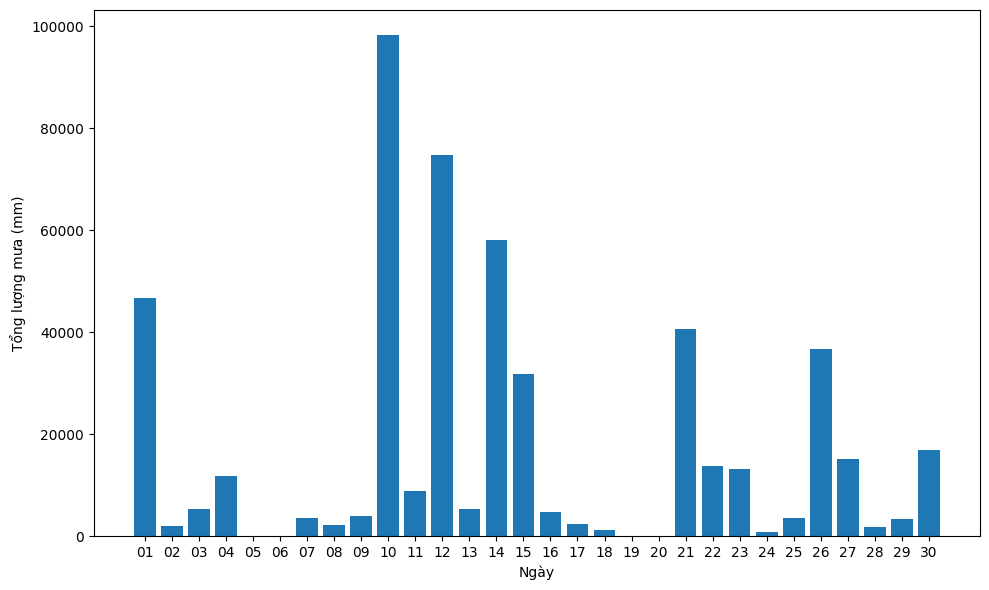

{'01': 46650.07294464111,
 '02': 1993.931234427262,
 '03': 5373.805045127869,
 '04': 11904.218307495117,
 '05': 0.0,
 '06': 0.0,
 '07': 3617.5736694335938,
 '08': 2222.526210308075,
 '09': 4015.899371338077,
 '10': 98251.666215837,
 '11': 8919.809743881226,
 '12': 74701.606680464,
 '13': 5285.286816716194,
 '14': 58113.61658859253,
 '15': 31777.26099510491,
 '16': 4747.326833799481,
 '17': 2355.197655275464,
 '18': 1168.3825063705444,
 '19': 0.6181249916553497,
 '20': 1.228749930858612,
 '21': 40692.23905105144,
 '22': 13859.748634338379,
 '23': 13094.599401473999,
 '24': 865.5987377138808,
 '25': 3606.3293430805206,
 '26': 36640.7427219362,
 '27': 15161.616694610566,
 '28': 1856.0930569171906,
 '29': 3297.0219235420227,
 '30': 16916.996052712202}

In [14]:
tiff_dir = './dataset/2019/04'

calculate_rainfall(tiff_dir)

Tháng 10/2019

Tổng lượng mưa trong tháng: 1414652.45 mm


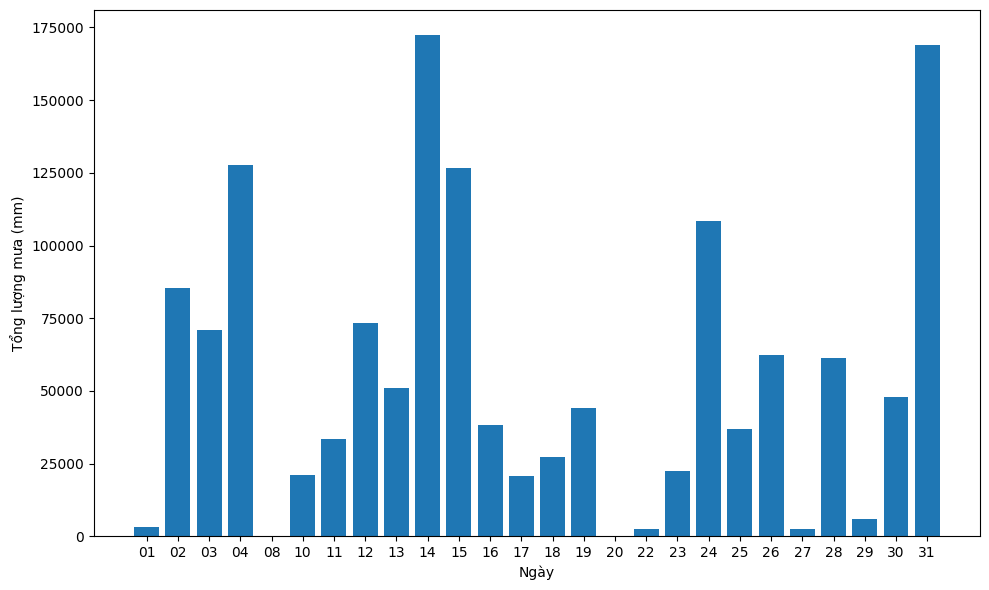

{'01': 3019.4251920701936,
 '02': 85440.2074381113,
 '03': 71061.89846801758,
 '04': 127751.33264160156,
 '08': 0.0,
 '10': 20917.70668029785,
 '11': 33433.70203399658,
 '12': 73259.55487060547,
 '13': 51027.07962036133,
 '14': 172394.9912109375,
 '15': 126613.50048828125,
 '16': 38286.16589355469,
 '17': 20572.610565185547,
 '18': 27086.369110107422,
 '19': 44260.103744506836,
 '20': 123.09811401367188,
 '22': 2605.414371728897,
 '23': 22552.524944365025,
 '24': 108428.13659667969,
 '25': 37018.805809020996,
 '26': 62169.662353515625,
 '27': 2362.6699981689453,
 '28': 61388.03106689453,
 '29': 5879.509222507477,
 '30': 48060.184034600854,
 '31': 168939.76347351074}

In [15]:
tiff_dir = './dataset/2019/10'

calculate_rainfall(tiff_dir)

Tháng 04/2020


Tổng lượng mưa trong tháng: 393108.06 mm


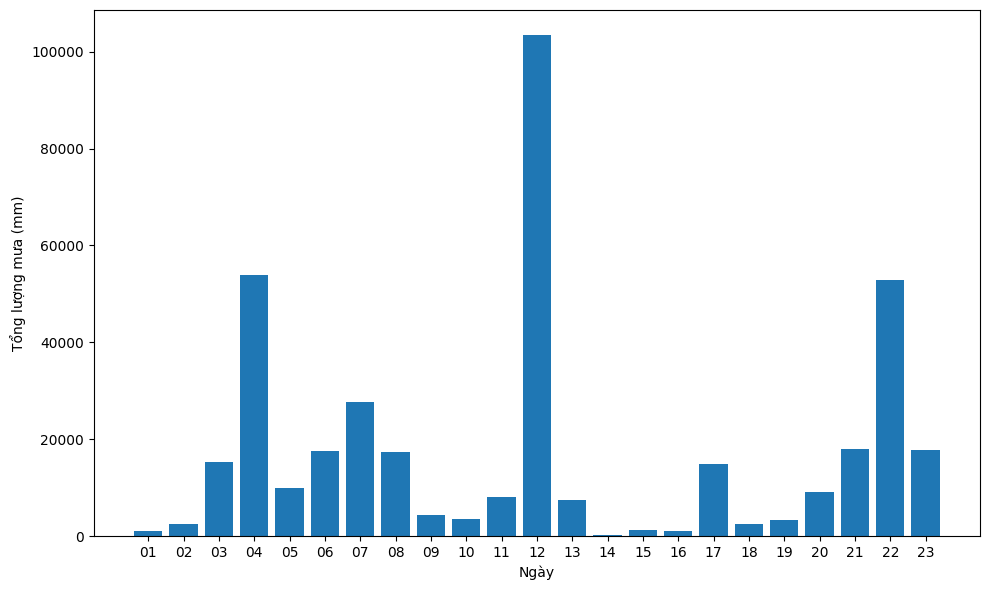

{'01': 983.234995670151,
 '02': 2465.043694615364,
 '03': 15264.406551122665,
 '04': 53979.773750305176,
 '05': 9856.287395477295,
 '06': 17573.19478213787,
 '07': 27719.510013002902,
 '08': 17381.25753068924,
 '09': 4453.135305047035,
 '10': 3527.317047595978,
 '11': 8014.279174536467,
 '12': 103427.62823486328,
 '13': 7460.51066181669,
 '14': 274.6656297966838,
 '15': 1204.7404534369707,
 '16': 1143.85267496109,
 '17': 14839.233292371035,
 '18': 2535.537979528308,
 '19': 3353.0300339758396,
 '20': 9023.6579682827,
 '21': 18073.626339673996,
 '22': 52855.76937866211,
 '23': 17698.365531921387}

In [16]:
tiff_dir = './dataset/2020/04'

calculate_rainfall(tiff_dir)

Tháng 10/2020


Tổng lượng mưa trong tháng: 4319307.80 mm


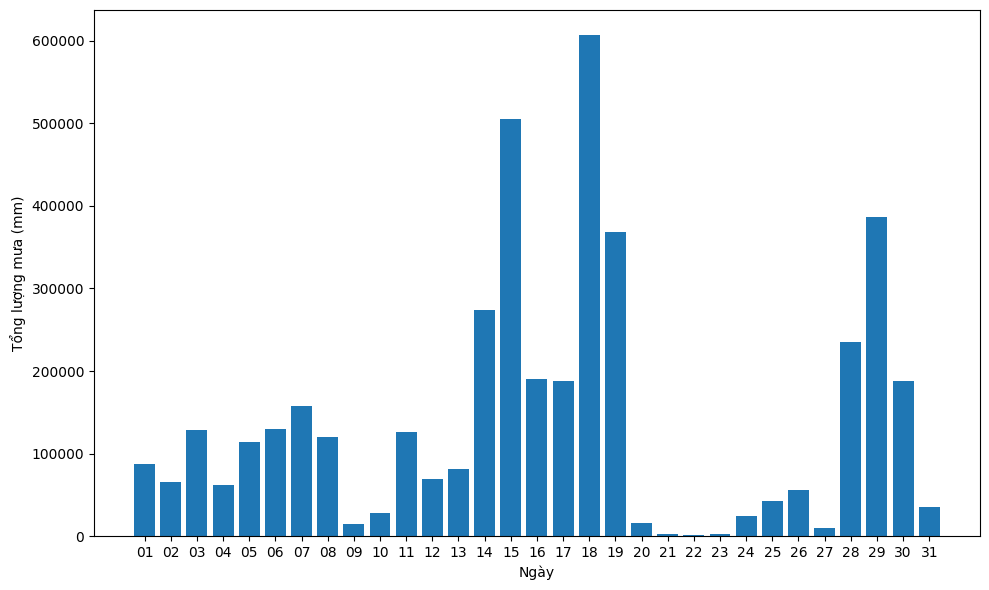

{'01': 87937.31127929688,
 '02': 65585.33966064453,
 '03': 128266.8296508789,
 '04': 61727.71694946289,
 '05': 114527.35021972656,
 '06': 130249.25512695312,
 '07': 157521.2646484375,
 '08': 119512.89147949219,
 '09': 14599.47817993164,
 '10': 28597.93087387085,
 '11': 126047.35925292969,
 '12': 69668.03192901611,
 '13': 81970.6226196289,
 '14': 274364.81396484375,
 '15': 504694.2099609375,
 '16': 190427.76440429688,
 '17': 187599.3984375,
 '18': 606681.2470703125,
 '19': 367788.1633300781,
 '20': 16542.87490081787,
 '21': 2722.2537412047386,
 '22': 1809.9575296342373,
 '23': 2903.601836748421,
 '24': 24210.394298791885,
 '25': 42349.56433105469,
 '26': 56359.72332763672,
 '27': 9471.216947555542,
 '28': 235167.26293945312,
 '29': 386854.48388671875,
 '30': 188339.36737060547,
 '31': 34810.11534881592}

In [17]:
tiff_dir = './dataset/2020/10'

calculate_rainfall(tiff_dir)

So sánh tổng lượng mưa

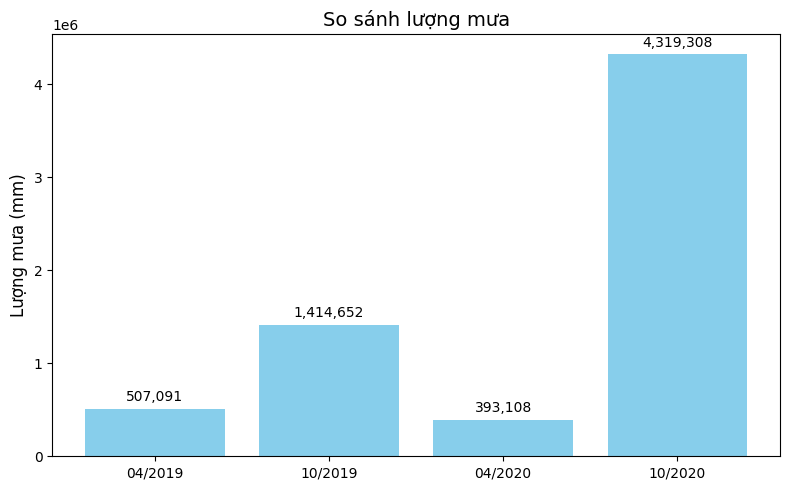

In [18]:

values = [507091.01, 1414652.45, 393108.06, 4319307.80]
labels = ['04/2019', '10/2019', '04/2020', '10/2020']  # Bạn có thể thay bằng tên tương ứng

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color='skyblue')

# Thêm nhãn số trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50000, f'{yval:,.0f}', 
             ha='center', va='bottom', fontsize=10)

# Tùy chỉnh trục
plt.ylabel('Lượng mưa (mm)', fontsize=12)
plt.title('So sánh lượng mưa', fontsize=14)
plt.tight_layout()
plt.show()


# **Nhận xét**

*   Tháng 10 thường có xu hướng mưa nhiều hơn tháng 4 trong năm
*   Dù có những ngày bị thiếu mất 1 khoảng thời gian trong ngày nhưng lượng mưa trong ngày vẫn tương đối



# **Fill khoảng trắng -inf**


*   Phương pháp 1: Fill với giá trị min = 0
*   Phương pháp 2: Sử dụng nội suy lân cận (nearest-neighbor interpolation)



In [19]:
def fill_inf_with_finite_image(image):

    min_finite = np.min(image[np.isfinite(image)])
    image[np.isneginf(image)] = min_finite
    return image

In [20]:
def fill_inf_with_interpolation(image):
    h, w = image.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    #take valid points
    valid_mask = np.isfinite(image)
    valid_points = np.column_stack((X[valid_mask], Y[valid_mask]))
    valid_values = image[valid_mask]

    #take inf points
    inf_mask = np.isneginf(image)
    inf_points = np.column_stack((X[inf_mask], Y[inf_mask]))

    #interpolation
    interpolated_values = griddata(valid_points, valid_values, inf_points, method='nearest')


    filled_image = image.copy()
    filled_image[inf_mask] = interpolated_values

    return filled_image

[      -inf       -inf 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

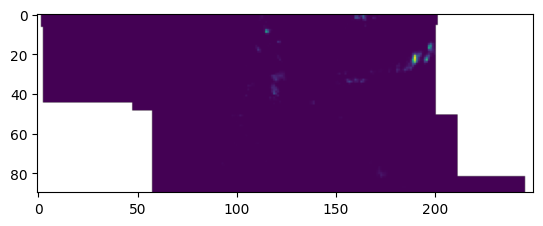

In [21]:
tiff = './dataset/2019/04/01/Radar_20190401000000.tif'

with rasterio.open(tiff) as image:
    image_array = image.read(1)

    print(image_array[0])
    show(image_array)


# **Fill với giá trị min = 0**

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

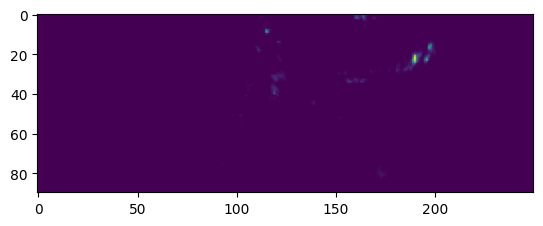

<Axes: >

In [22]:
image_array_fix_1 = fill_inf_with_finite_image(image_array)
print(image_array_fix_1[0])
show(image_array_fix_1)

# **Sử dụng nội suy lân cận (nearest-neighbor interpolation)**

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

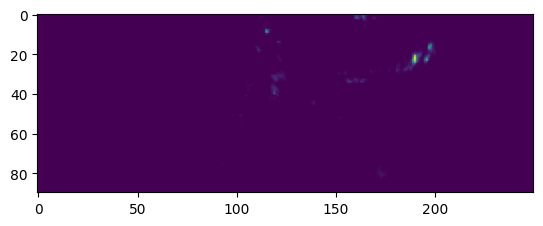

<Axes: >

In [23]:
image_array_fix_2 = fill_inf_with_interpolation(image_array)
print(image_array_fix_2[0])
show(image_array_fix_2)